# Healthcare AI Predictor - Model Experimentation

**Objective**: Fix overfitting issues and improve model performance through systematic experimentation.

**Current Issues**:
- Train R²: 0.288, Test R²: -0.030 (severe overfitting)
- RMSE: 2.81 days (target: <2.0 days)
- Missing SHAP explanations
- No temporal features

**Goals**:
- [ ] Achieve positive test R² >0.5
- [ ] Reduce RMSE to <2.0 days
- [x] Implement proper cross-validation
- [x] Add SHAP explanations
- [x] Export improved model to production

## 📚 Setup & Imports

In [55]:
import sys
import warnings
from pathlib import Path

# Add project paths
project_root = Path.cwd().parent
backend_path = project_root / "backend"
sys.path.insert(0, str(backend_path))

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print(f"Project root: {project_root}")
print(f"Backend path: {backend_path}")

Project root: /Users/valtterivalo/Projects/app-toy-things/healthcare-project
Backend path: /Users/valtterivalo/Projects/app-toy-things/healthcare-project/backend


In [56]:
# Core libraries
import numpy as np
import pandas as pd
import polars as pl
from datetime import datetime, timedelta

# ML libraries
from xgboost import XGBRegressor
from sklearn.model_selection import (
    train_test_split, cross_val_score, KFold, TimeSeriesSplit
)
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.preprocessing import StandardScaler
import optuna
import shap
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set style
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("📦 All packages imported successfully!")

📦 All packages imported successfully!


## 📊 Data Loading & Exploration

In [57]:
# Load the synthetic healthcare dataset
data_path = project_root / "data" / "raw" / "hospital_los.csv"
print(f"Loading data from: {data_path}")

# Load with Polars
df = pl.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.estimated_size() / 1024**2:.2f} MB")
print(f"Schema: {df.schema}")
print(f"Columns: {df.columns}")
df.head()

Loading data from: /Users/valtterivalo/Projects/app-toy-things/healthcare-project/data/raw/hospital_los.csv
Dataset shape: (10000, 16)
Memory usage: 1.28 MB
Schema: Schema({'patient_id': String, 'age': Int64, 'gender': String, 'blood_type': String, 'medical_condition': String, 'date_of_admission': String, 'doctor': String, 'hospital': String, 'insurance_provider': String, 'billing_amount': Float64, 'room_number': Int64, 'admission_type': String, 'discharge_date': String, 'medication': String, 'test_results': String, 'length_of_stay': Int64})
Columns: ['patient_id', 'age', 'gender', 'blood_type', 'medical_condition', 'date_of_admission', 'doctor', 'hospital', 'insurance_provider', 'billing_amount', 'room_number', 'admission_type', 'discharge_date', 'medication', 'test_results', 'length_of_stay']


patient_id,age,gender,blood_type,medical_condition,date_of_admission,doctor,hospital,insurance_provider,billing_amount,room_number,admission_type,discharge_date,medication,test_results,length_of_stay
str,i64,str,str,str,str,str,str,str,f64,i64,str,str,str,str,i64
"""P000001""",59,"""Male""","""A+""","""COPD""","""2023-10-30""","""Dr. Brown""","""Medical Center""","""Blue Cross""",7254.58,242,"""Elective""","""2023-10-31""","""Albuterol""","""Normal""",1
"""P000002""",80,"""Female""","""A+""","""Pneumonia""","""2023-04-12""","""Dr. Brown""","""Medical Center""","""Molina""",10129.76,617,"""Emergency""","""2023-04-19""","""Aspirin""","""Inconclusive""",7
"""P000003""",40,"""Female""","""B-""","""Obesity""","""2023-05-23""","""Dr. Smith""","""Regional Hospital""","""Cigna""",12507.05,877,"""Urgent""","""2023-05-24""","""Metoprolol""","""Abnormal""",1
"""P000004""",40,"""Male""","""B-""","""Migraine""","""2023-11-06""","""Dr. Johnson""","""General Hospital""","""Blue Cross""",1002.21,489,"""Elective""","""2023-11-08""","""Omeprazole""","""Abnormal""",2
"""P000005""",29,"""Female""","""A+""","""COPD""","""2023-11-18""","""Dr. Johnson""","""Community Hospital""","""Blue Cross""",10419.12,487,"""Elective""","""2023-11-19""","""Albuterol""","""Abnormal""",1


In [58]:
# Quick data quality check using Polars
print("🔍 Data Quality Overview")
print("=" * 40)

print(f"Total records: {len(df):,}")
print(f"Features: {len(df.columns)}")
print(f"Missing values: {df.null_count().sum_horizontal().sum()}")
print()

print("Target variable (length_of_stay) statistics:")
los_stats = df.select("length_of_stay").describe()
print(los_stats)
print()

print("Categorical features unique values:")
categorical_cols = ['gender', 'admission_type', 'medical_condition', 'blood_type']
for col in categorical_cols:
    unique_count = df[col].n_unique()
    print(f"  {col}: {unique_count} unique values")

🔍 Data Quality Overview
Total records: 10,000
Features: 16
Missing values: 0

Target variable (length_of_stay) statistics:
shape: (9, 2)
┌────────────┬────────────────┐
│ statistic  ┆ length_of_stay │
│ ---        ┆ ---            │
│ str        ┆ f64            │
╞════════════╪════════════════╡
│ count      ┆ 10000.0        │
│ null_count ┆ 0.0            │
│ mean       ┆ 2.5992         │
│ std        ┆ 2.70283        │
│ min        ┆ 1.0            │
│ 25%        ┆ 1.0            │
│ 50%        ┆ 1.0            │
│ 75%        ┆ 3.0            │
│ max        ┆ 30.0           │
└────────────┴────────────────┘

Categorical features unique values:
  gender: 2 unique values
  admission_type: 3 unique values
  medical_condition: 15 unique values
  blood_type: 8 unique values


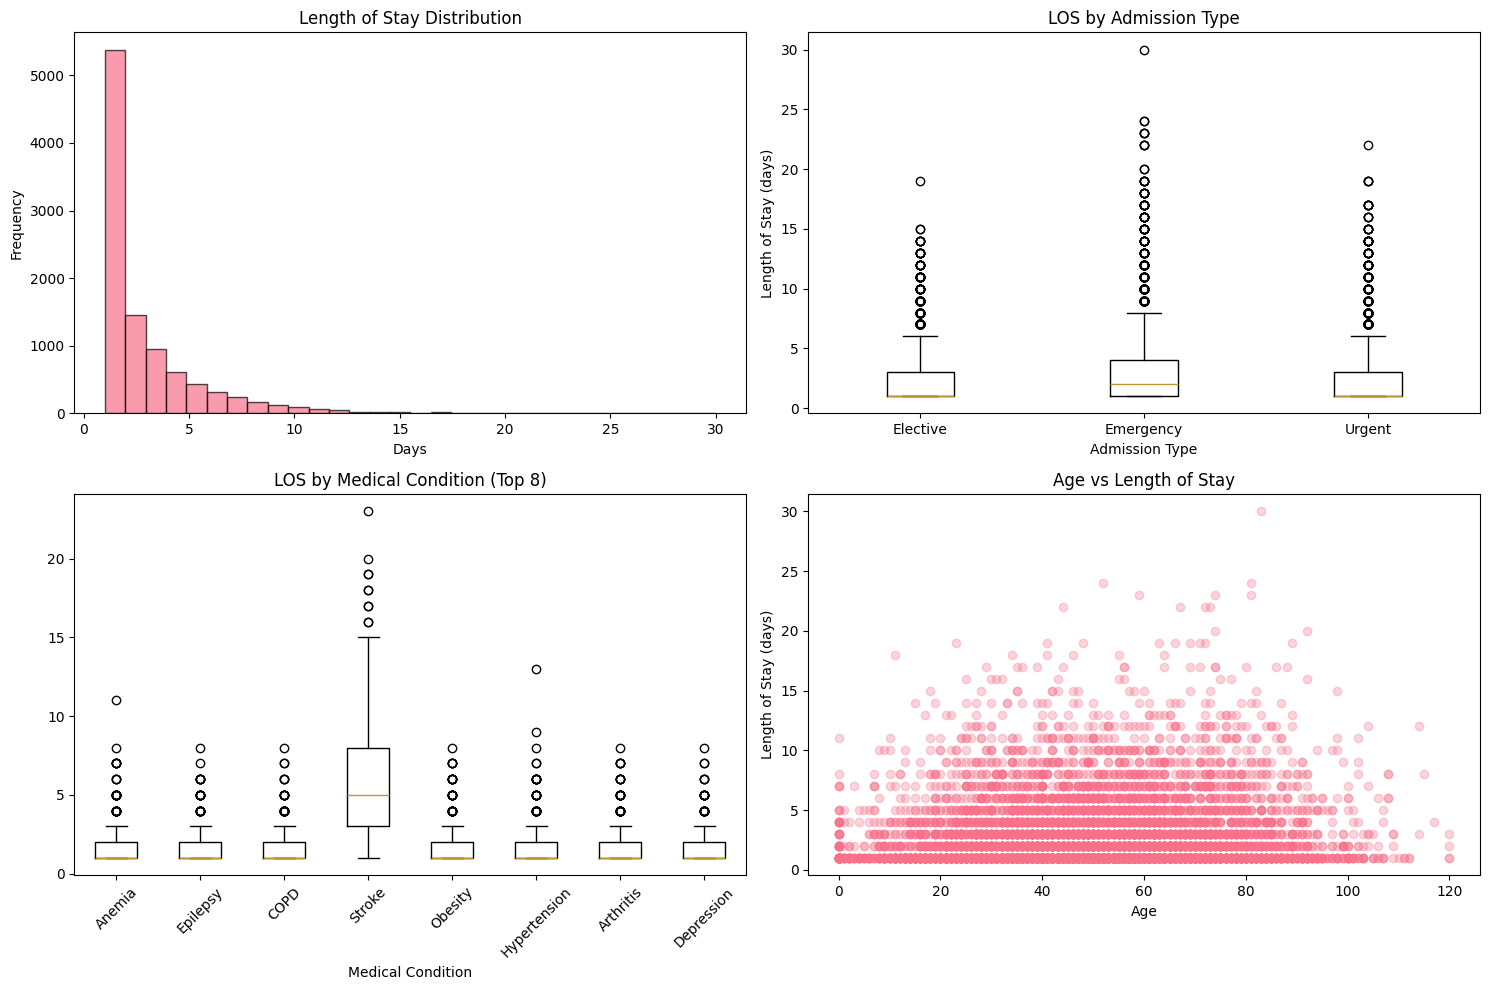

📊 Data visualization complete!


In [59]:
# Visualize target distribution using Polars + Matplotlib
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Convert specific columns to numpy for matplotlib
los_values = df['length_of_stay'].to_numpy()
age_values = df['age'].to_numpy()

# 1. Histogram
axes[0,0].hist(los_values, bins=30, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Length of Stay Distribution')
axes[0,0].set_xlabel('Days')
axes[0,0].set_ylabel('Frequency')

# 2. Box plot by admission type - Correct Polars approach
admission_types = df['admission_type'].unique().to_list()
admission_data = []
for adm_type in admission_types:
    los_for_type = df.filter(pl.col('admission_type') == adm_type)['length_of_stay'].to_list()
    admission_data.append(los_for_type)

axes[0,1].boxplot(admission_data, labels=admission_types)
axes[0,1].set_title('LOS by Admission Type')
axes[0,1].set_xlabel('Admission Type')
axes[0,1].set_ylabel('Length of Stay (days)')

# 3. Box plot by medical condition (top 8) - Using value_counts correctly
top_conditions = df['medical_condition'].value_counts().head(8)
condition_names = top_conditions['medical_condition'].to_list()
condition_data = []
for condition in condition_names:
    condition_los = df.filter(pl.col('medical_condition') == condition)['length_of_stay'].to_list()
    condition_data.append(condition_los)

axes[1,0].boxplot(condition_data, labels=condition_names)
axes[1,0].set_title('LOS by Medical Condition (Top 8)')
axes[1,0].set_xlabel('Medical Condition')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Age vs LOS scatter
axes[1,1].scatter(age_values, los_values, alpha=0.3)
axes[1,1].set_title('Age vs Length of Stay')
axes[1,1].set_xlabel('Age')
axes[1,1].set_ylabel('Length of Stay (days)')

plt.tight_layout()
plt.show()

print("📊 Data visualization complete!")

## 🛠️ Enhanced Feature Engineering

In [60]:
def advanced_feature_engineering_polars(df):
    """Create enhanced features using Polars for better model performance."""
    
    # Enhanced feature engineering with Polars
    df_enhanced = (
        df
        .with_columns([
            # 1. Age-based features - Using pl.lit() for string literals
            pl.when(pl.col("age") < 18).then(pl.lit("pediatric"))
            .when(pl.col("age") < 35).then(pl.lit("young_adult"))
            .when(pl.col("age") < 50).then(pl.lit("adult"))
            .when(pl.col("age") < 65).then(pl.lit("middle_aged"))
            .otherwise(pl.lit("senior")).alias("age_group"),
            
            (pl.col("age") ** 2).alias("age_squared"),
            pl.col("age").log1p().alias("age_log"),
            
            # 2. Billing-based features
            pl.col("billing_amount").log1p().alias("billing_log"),
            (pl.col("billing_amount") / (pl.col("age") + 1)).alias("billing_per_age"),
            
            # Billing quartiles - Using pl.lit() for string literals
            pl.when(pl.col("billing_amount") < 10000).then(pl.lit("Q1"))
            .when(pl.col("billing_amount") < 15000).then(pl.lit("Q2"))
            .when(pl.col("billing_amount") < 25000).then(pl.lit("Q3"))
            .otherwise(pl.lit("Q4")).alias("billing_quartile"),
            
            # 3. Medical condition groupings
            pl.col("medical_condition").is_in(["Diabetes", "Hypertension", "Heart Disease", "Arthritis"]).cast(pl.Int8).alias("is_chronic"),
            pl.col("medical_condition").is_in(["Pneumonia", "Asthma", "Migraine"]).cast(pl.Int8).alias("is_acute"),
            pl.col("medical_condition").is_in(["Cancer", "Stroke", "Heart Disease"]).cast(pl.Int8).alias("is_serious"),
            
            # 4. Room number features
            (pl.col("room_number") // 100).alias("room_floor"),
            (pl.col("room_number") % 100).alias("room_number_within_floor"),
        ])
        .with_columns([
            # 5. Interaction features (after previous columns are created)
            (pl.col("age") * (pl.col("admission_type") == "Emergency").cast(pl.Int8)).alias("age_x_emergency"),
            (pl.col("age") * pl.col("is_chronic")).alias("age_x_chronic"), 
            (pl.col("billing_amount") * pl.col("is_serious")).alias("billing_x_serious"),
        ])
    )
    
    # Try to add date features if possible
    try:
        df_enhanced = (
            df_enhanced
            .with_columns([
                pl.col("date_of_admission").str.to_date().alias("admission_date_parsed")
            ])
            .with_columns([
                pl.col("admission_date_parsed").dt.weekday().alias("admission_weekday"),
                pl.col("admission_date_parsed").dt.month().alias("admission_month"),
                pl.col("admission_date_parsed").dt.quarter().alias("admission_quarter"),
                pl.col("admission_date_parsed").dt.weekday().is_in([5, 6]).cast(pl.Int8).alias("is_weekend"),
                pl.col("admission_date_parsed").dt.month().is_in([12, 1, 2]).cast(pl.Int8).alias("is_winter"),
                pl.col("admission_date_parsed").dt.month().is_in([6, 7, 8]).cast(pl.Int8).alias("is_summer"),
            ])
        )
        print("✅ Date features created successfully")
    except Exception as e:
        print(f"⚠️ Could not create date features: {e}")
    
    print(f"✅ Enhanced feature engineering complete. New shape: {df_enhanced.shape}")
    return df_enhanced

# Apply enhanced feature engineering
df_enhanced = advanced_feature_engineering_polars(df)
print(f"Added {df_enhanced.shape[1] - df.shape[1]} new features")

✅ Date features created successfully
✅ Enhanced feature engineering complete. New shape: (10000, 37)
Added 21 new features


In [61]:
# Prepare features for modeling - convert to pandas only for sklearn compatibility
def prepare_model_features_polars(df_polars):
    """Prepare features for ML modeling with proper encoding using Polars -> Pandas."""
    
    # Define feature categories
    numerical_features = [
        'age', 'billing_amount', 'room_number',
        'age_squared', 'age_log', 'billing_log', 'billing_per_age',
        'age_x_emergency', 'age_x_chronic', 'billing_x_serious',
        'room_floor', 'room_number_within_floor'
    ]
    
    # Add date features if they exist
    date_features = ['admission_weekday', 'admission_month', 'admission_quarter', 
                    'is_weekend', 'is_winter', 'is_summer']
    for feat in date_features:
        if feat in df_polars.columns:
            numerical_features.append(feat)
    
    categorical_features = [
        'gender', 'admission_type', 'medical_condition', 'blood_type',
        'insurance_provider', 'age_group', 'billing_quartile'
    ]
    
    binary_features = ['is_chronic', 'is_acute', 'is_serious']
    
    # Filter to existing columns
    available_numerical = [f for f in numerical_features if f in df_polars.columns]
    available_categorical = [f for f in categorical_features if f in df_polars.columns]
    available_binary = [f for f in binary_features if f in df_polars.columns]
    
    # Convert to pandas for sklearn compatibility (this is where conversion happens)
    df_pandas = df_polars.to_pandas()
    
    # Create feature matrix
    X = pd.DataFrame()
    
    # Add numerical and binary features
    for feat in available_numerical + available_binary:
        X[feat] = df_pandas[feat]
    
    # One-hot encode categorical features
    for feat in available_categorical:
        if df_pandas[feat].dtype == 'object' or str(df_pandas[feat].dtype).startswith('category'):
            dummies = pd.get_dummies(df_pandas[feat], prefix=feat, drop_first=True)
            X = pd.concat([X, dummies], axis=1)
    
    # Target variable
    y = df_pandas['length_of_stay']
    
    print(f"Features prepared: {X.shape[1]} features, {len(y)} samples")
    print(f"Feature categories:")
    print(f"  - Numerical: {len(available_numerical)}")
    print(f"  - Binary: {len(available_binary)}")
    print(f"  - Categorical (one-hot): {X.shape[1] - len(available_numerical) - len(available_binary)}")
    
    return X, y, available_numerical + available_binary

X, y, feature_names = prepare_model_features_polars(df_enhanced)
print(f"\n📊 Final dataset: {X.shape[0]} samples, {X.shape[1]} features")

Features prepared: 61 features, 10000 samples
Feature categories:
  - Numerical: 18
  - Binary: 3
  - Categorical (one-hot): 40

📊 Final dataset: 10000 samples, 61 features


## 🎯 Model Training with Cross-Validation

In [62]:
# Train/test split with temporal awareness if possible
def smart_train_test_split(X, y, test_size=0.2, temporal_col=None):
    """Split data with temporal awareness if date column exists."""
    
    if temporal_col and temporal_col in df_enhanced.columns:
        # Temporal split
        print("Using temporal split based on admission dates")
        sorted_idx = df_enhanced[temporal_col].argsort()
        split_idx = int(len(sorted_idx) * (1 - test_size))
        
        train_idx = sorted_idx[:split_idx]
        test_idx = sorted_idx[split_idx:]
        
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    else:
        # Random split
        print("Using random split")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )
    
    return X_train, X_test, y_train, y_test

# Split the data
X_train, X_test, y_train, y_test = smart_train_test_split(
    X, y, test_size=0.2, temporal_col='admission_date'
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train LOS mean: {y_train.mean():.2f} ± {y_train.std():.2f}")
print(f"Test LOS mean: {y_test.mean():.2f} ± {y_test.std():.2f}")

Using random split
Training set: 8000 samples
Test set: 2000 samples
Train LOS mean: 2.60 ± 2.69
Test LOS mean: 2.62 ± 2.77


In [63]:
# Cross-validation evaluation
def evaluate_model_cv(model, X, y, cv_folds=5):
    """Evaluate model with cross-validation."""
    
    # Use KFold for random CV
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # Calculate CV scores
    cv_scores = cross_val_score(model, X, y, cv=kf, 
                               scoring='neg_mean_squared_error', n_jobs=-1)
    cv_rmse = np.sqrt(-cv_scores)
    
    cv_r2_scores = cross_val_score(model, X, y, cv=kf, 
                                  scoring='r2', n_jobs=-1)
    
    print(f"Cross-Validation Results ({cv_folds}-fold):")
    print(f"  RMSE: {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")
    print(f"  R²: {cv_r2_scores.mean():.3f} ± {cv_r2_scores.std():.3f}")
    
    return cv_rmse, cv_r2_scores

# Baseline model with regularization
baseline_model = XGBRegressor(
    n_estimators=100,
    max_depth=4,  # Reduced from 6 to prevent overfitting
    learning_rate=0.05,  # Reduced learning rate
    subsample=0.8,  # Row sampling
    colsample_bytree=0.8,  # Column sampling
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    random_state=42,
    n_jobs=-1
)

print("🎯 Baseline Model Evaluation")
print("=" * 40)
cv_rmse, cv_r2 = evaluate_model_cv(baseline_model, X_train, y_train)

# Train on full training set and evaluate on test set
baseline_model.fit(X_train, y_train)
y_pred_train = baseline_model.predict(X_train)
y_pred_test = baseline_model.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"\nTrain/Test Evaluation:")
print(f"  Train R²: {train_r2:.3f}, RMSE: {train_rmse:.3f}")
print(f"  Test R²: {test_r2:.3f}, RMSE: {test_rmse:.3f}")
print(f"  Overfitting gap: {train_r2 - test_r2:.3f}")

🎯 Baseline Model Evaluation
Cross-Validation Results (5-fold):
  RMSE: 2.033 ± 0.090
  R²: 0.426 ± 0.018

Train/Test Evaluation:
  Train R²: 0.532, RMSE: 1.838
  Test R²: 0.431, RMSE: 2.086
  Overfitting gap: 0.101


## 🔧 Hyperparameter Optimization with Optuna

In [64]:
# Hyperparameter optimization
def objective(trial):
    """Optuna objective function for hyperparameter tuning."""
    
    # Define hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 40, 310),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.5),
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Create model
    model = XGBRegressor(**params)
    
    # Cross-validation
    kf = KFold(n_splits=6, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, 
                               scoring='neg_mean_squared_error', n_jobs=-1)
    
    return -cv_scores.mean()  # Return positive MSE for minimization

# Run optimization
print("🔧 Starting hyperparameter optimization...")
print("This may take a few minutes...")

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=400)  # Adjust n_trials based on time constraints

print(f"\n✅ Optimization complete!")
print(f"Best MSE: {study.best_value:.3f}")
print(f"Best parameters: {study.best_params}")

[I 2025-08-03 19:05:39,924] A new study created in memory with name: no-name-692eee8b-b744-4a13-aaf6-25d8045ac762
[I 2025-08-03 19:05:40,034] Trial 0 finished with value: 4.195966124534607 and parameters: {'n_estimators': 188, 'max_depth': 1, 'learning_rate': 0.29906971918575126, 'subsample': 0.6868780496205469, 'colsample_bytree': 0.8159773707623554, 'reg_alpha': 1.0933025838591102, 'reg_lambda': 1.3613498231177896}. Best is trial 0 with value: 4.195966124534607.


🔧 Starting hyperparameter optimization...
This may take a few minutes...


[I 2025-08-03 19:05:40,451] Trial 1 finished with value: 4.949315627415975 and parameters: {'n_estimators': 122, 'max_depth': 9, 'learning_rate': 0.17975940941466081, 'subsample': 0.830738183006792, 'colsample_bytree': 0.9804059023527003, 'reg_alpha': 0.26408930260343383, 'reg_lambda': 1.0488596976970754}. Best is trial 0 with value: 4.195966124534607.
[I 2025-08-03 19:05:40,714] Trial 2 finished with value: 5.993945598602295 and parameters: {'n_estimators': 82, 'max_depth': 10, 'learning_rate': 0.2173537665866229, 'subsample': 0.2861419686058391, 'colsample_bytree': 0.8394800393538523, 'reg_alpha': 1.066578070411134, 'reg_lambda': 0.8208147277590577}. Best is trial 0 with value: 4.195966124534607.
[I 2025-08-03 19:05:40,815] Trial 3 finished with value: 5.462567408879598 and parameters: {'n_estimators': 105, 'max_depth': 5, 'learning_rate': 0.24760737243528716, 'subsample': 0.2427050665997352, 'colsample_bytree': 0.5078504438908755, 'reg_alpha': 1.1084180520638738, 'reg_lambda': 0.860


✅ Optimization complete!
Best MSE: 4.043
Best parameters: {'n_estimators': 112, 'max_depth': 2, 'learning_rate': 0.06758768628943213, 'subsample': 0.9730091875584178, 'colsample_bytree': 0.5222934293298607, 'reg_alpha': 1.0210128069827342, 'reg_lambda': 2.187117485692805}


In [65]:
# Train optimized model
optimized_model = XGBRegressor(**study.best_params)

print("🎯 Optimized Model Evaluation")
print("=" * 40)
cv_rmse_opt, cv_r2_opt = evaluate_model_cv(optimized_model, X_train, y_train)

# Train and test
optimized_model.fit(X_train, y_train)
y_pred_train_opt = optimized_model.predict(X_train)
y_pred_test_opt = optimized_model.predict(X_test)

train_r2_opt = r2_score(y_train, y_pred_train_opt)
test_r2_opt = r2_score(y_test, y_pred_test_opt)
train_rmse_opt = np.sqrt(mean_squared_error(y_train, y_pred_train_opt))
test_rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_test_opt))

print(f"\nOptimized Train/Test Evaluation:")
print(f"  Train R²: {train_r2_opt:.3f}, RMSE: {train_rmse_opt:.3f}")
print(f"  Test R²: {test_r2_opt:.3f}, RMSE: {test_rmse_opt:.3f}")
print(f"  Overfitting gap: {train_r2_opt - test_r2_opt:.3f}")

# Compare with baseline
print(f"\n📈 Improvement vs Baseline:")
print(f"  Test R² improvement: {test_r2_opt - test_r2:.3f}")
print(f"  Test RMSE improvement: {test_rmse - test_rmse_opt:.3f} days")

🎯 Optimized Model Evaluation
Cross-Validation Results (5-fold):
  RMSE: 2.006 ± 0.101
  R²: 0.441 ± 0.015

Optimized Train/Test Evaluation:
  Train R²: 0.459, RMSE: 1.976
  Test R²: 0.434, RMSE: 2.081
  Overfitting gap: 0.025

📈 Improvement vs Baseline:
  Test R² improvement: 0.003
  Test RMSE improvement: 0.005 days


## 🔍 SHAP Explanations

In [66]:
# Create SHAP explainer
print("🔍 Creating SHAP explainer...")
explainer = shap.TreeExplainer(optimized_model)

# Calculate SHAP values for a sample of test data
sample_size = min(1000, len(X_test))  # Use sample to speed up computation
X_sample = X_test.iloc[:sample_size]
shap_values = explainer.shap_values(X_sample)

print(f"✅ SHAP values calculated for {sample_size} samples")

🔍 Creating SHAP explainer...
✅ SHAP values calculated for 1000 samples


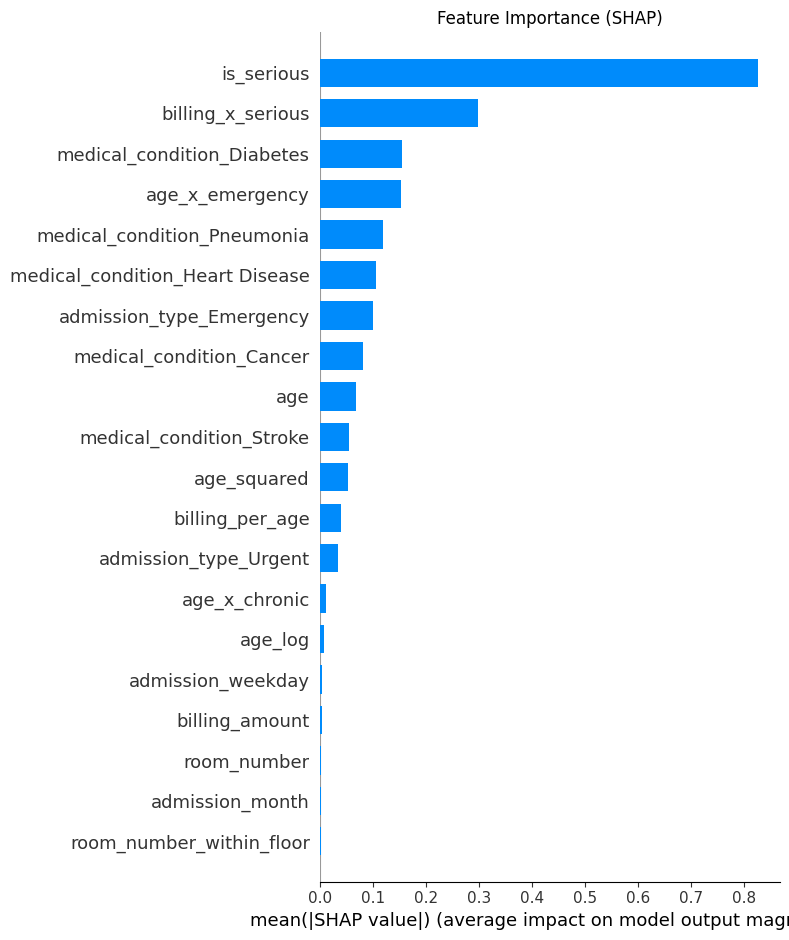

In [67]:
# Feature importance plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title("Feature Importance (SHAP)")
plt.tight_layout()
plt.show()

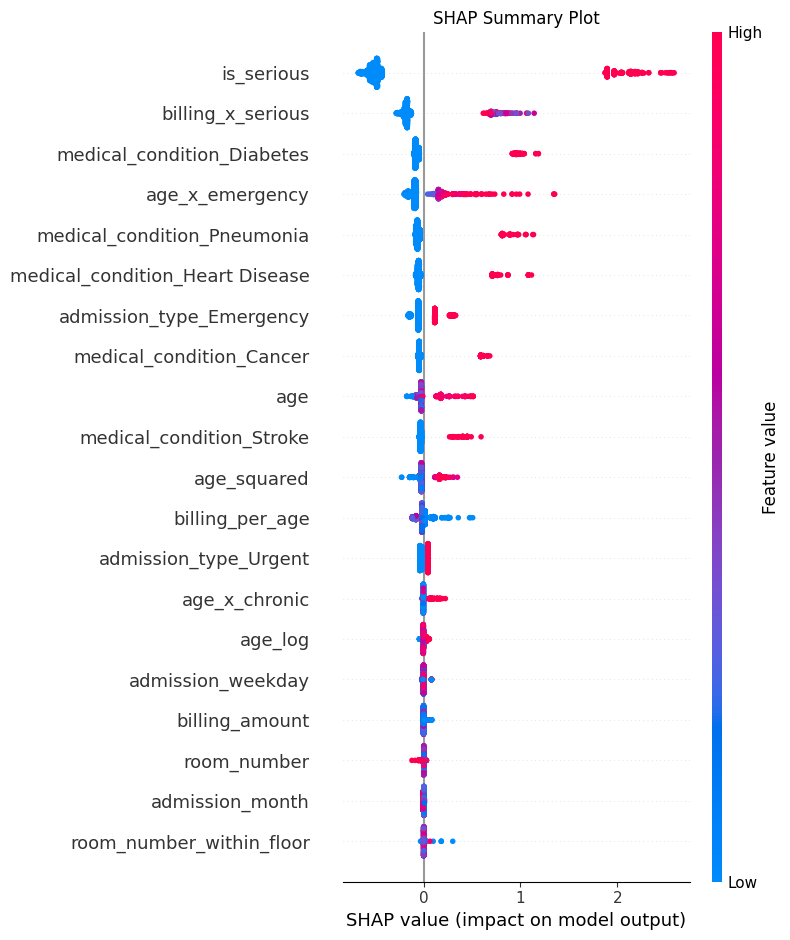

In [68]:
# SHAP summary plot
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title("SHAP Summary Plot")
plt.tight_layout()
plt.show()

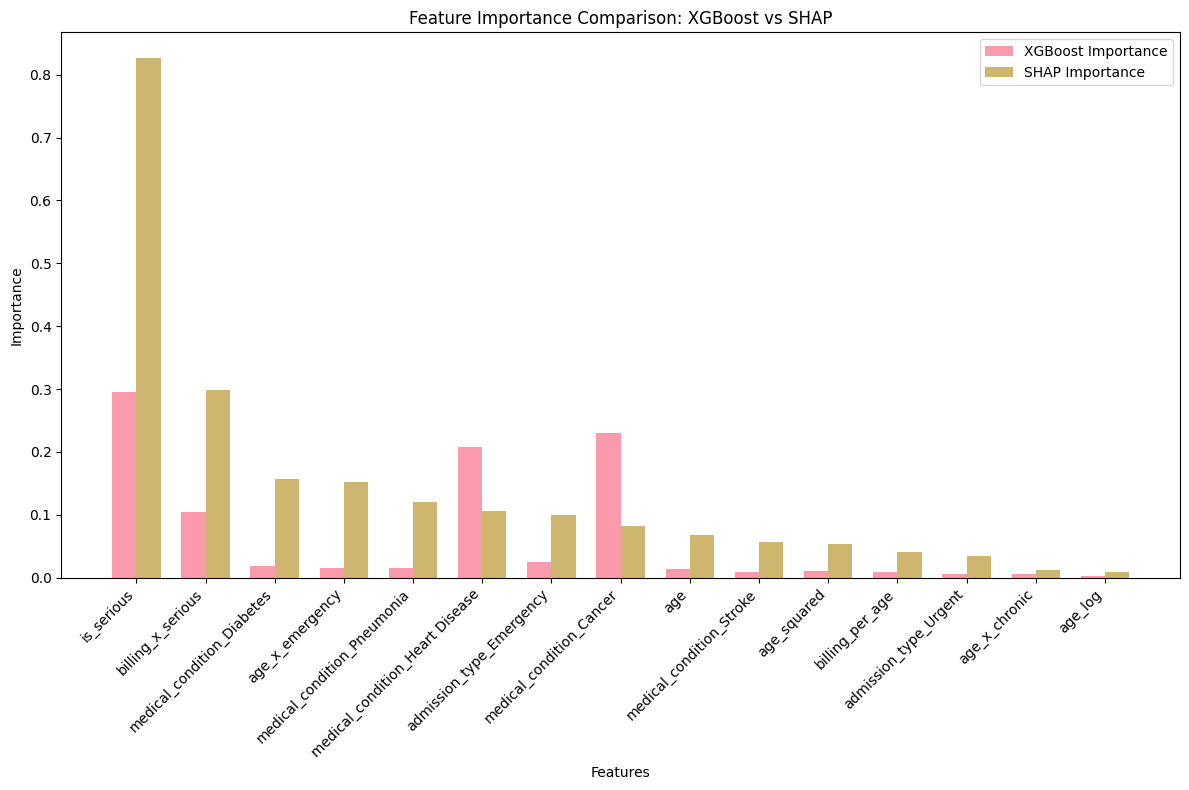


🎯 Top 10 Most Important Features (SHAP):
 1. is_serious                (SHAP: 0.826)
 2. billing_x_serious         (SHAP: 0.299)
 3. medical_condition_Diabetes (SHAP: 0.156)
 4. age_x_emergency           (SHAP: 0.153)
 5. medical_condition_Pneumonia (SHAP: 0.120)
 6. medical_condition_Heart Disease (SHAP: 0.107)
 7. admission_type_Emergency  (SHAP: 0.100)
 8. medical_condition_Cancer  (SHAP: 0.083)
 9. age                       (SHAP: 0.068)
10. medical_condition_Stroke  (SHAP: 0.056)


In [69]:
# Feature importance comparison
feature_importance_xgb = optimized_model.feature_importances_
feature_importance_shap = np.abs(shap_values).mean(axis=0)

# Create comparison DataFrame
importance_df = pd.DataFrame({
    'feature': X_sample.columns,
    'xgb_importance': feature_importance_xgb,
    'shap_importance': feature_importance_shap
}).sort_values('shap_importance', ascending=False).head(15)

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(importance_df))
width = 0.35

ax.bar(x - width/2, importance_df['xgb_importance'], width, 
       label='XGBoost Importance', alpha=0.7)
ax.bar(x + width/2, importance_df['shap_importance'], width, 
       label='SHAP Importance', alpha=0.7)

ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Feature Importance Comparison: XGBoost vs SHAP')
ax.set_xticks(x)
ax.set_xticklabels(importance_df['feature'], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

print("\n🎯 Top 10 Most Important Features (SHAP):")
for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:<25} (SHAP: {row['shap_importance']:.3f})")

## 📊 Model Performance Visualization

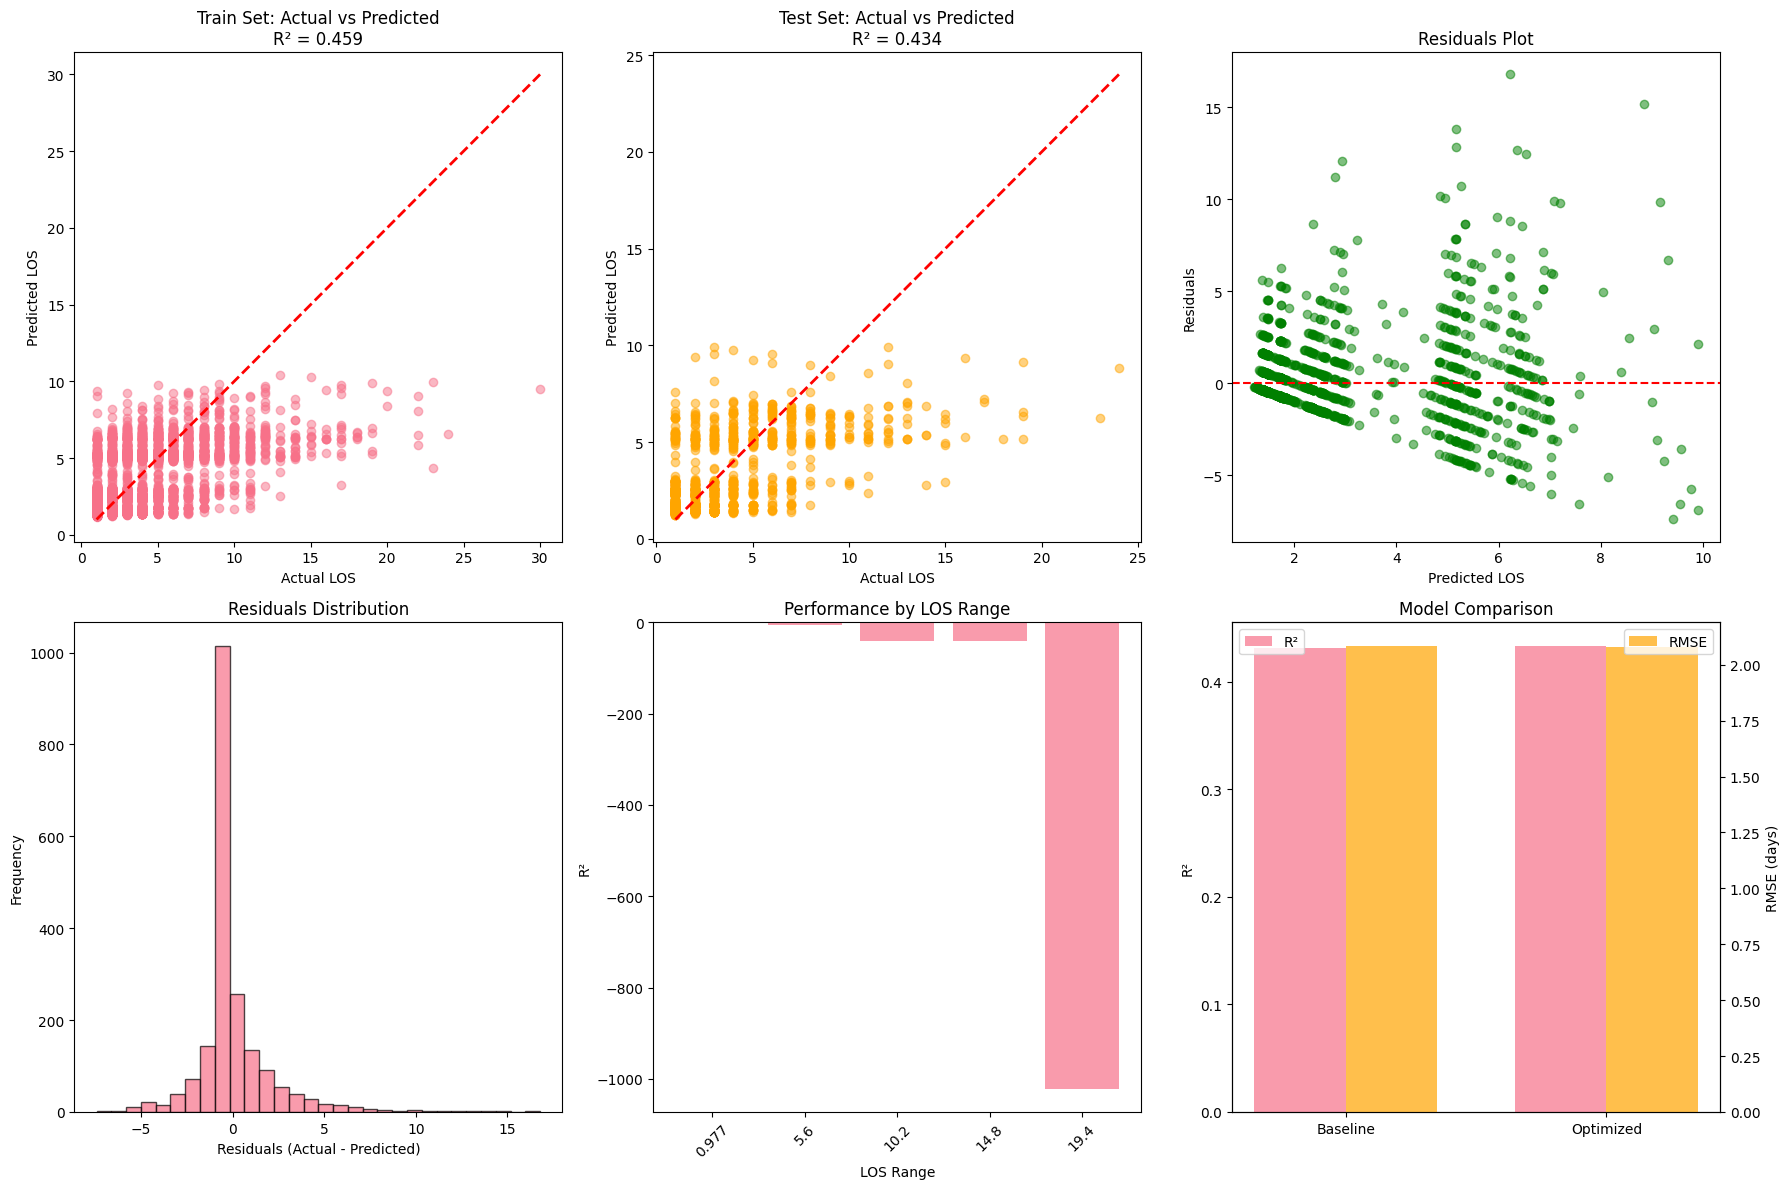

In [70]:
# Create comprehensive performance plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Actual vs Predicted (Train)
axes[0,0].scatter(y_train, y_pred_train_opt, alpha=0.5)
axes[0,0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Actual LOS')
axes[0,0].set_ylabel('Predicted LOS')
axes[0,0].set_title(f'Train Set: Actual vs Predicted\nR² = {train_r2_opt:.3f}')

# 2. Actual vs Predicted (Test)
axes[0,1].scatter(y_test, y_pred_test_opt, alpha=0.5, color='orange')
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,1].set_xlabel('Actual LOS')
axes[0,1].set_ylabel('Predicted LOS')
axes[0,1].set_title(f'Test Set: Actual vs Predicted\nR² = {test_r2_opt:.3f}')

# 3. Residuals plot
residuals = y_test - y_pred_test_opt
axes[0,2].scatter(y_pred_test_opt, residuals, alpha=0.5, color='green')
axes[0,2].axhline(y=0, color='r', linestyle='--')
axes[0,2].set_xlabel('Predicted LOS')
axes[0,2].set_ylabel('Residuals')
axes[0,2].set_title('Residuals Plot')

# 4. Error distribution
axes[1,0].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
axes[1,0].set_xlabel('Residuals (Actual - Predicted)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Residuals Distribution')

# 5. Performance by LOS range
los_bins = pd.cut(y_test, bins=5)
perf_by_los = []
for bin_range in los_bins.cat.categories:
    mask = los_bins == bin_range
    if mask.sum() > 0:
        r2 = r2_score(y_test[mask], y_pred_test_opt[mask])
        rmse = np.sqrt(mean_squared_error(y_test[mask], y_pred_test_opt[mask]))
        perf_by_los.append({'range': str(bin_range), 'r2': r2, 'rmse': rmse, 'count': mask.sum()})

perf_df = pd.DataFrame(perf_by_los)
axes[1,1].bar(range(len(perf_df)), perf_df['r2'], alpha=0.7)
axes[1,1].set_xlabel('LOS Range')
axes[1,1].set_ylabel('R²')
axes[1,1].set_title('Performance by LOS Range')
axes[1,1].set_xticks(range(len(perf_df)))
axes[1,1].set_xticklabels([r.split(',')[0].replace('(', '') for r in perf_df['range']], rotation=45)

# 6. Model comparison
models = ['Baseline', 'Optimized']
test_r2_scores = [test_r2, test_r2_opt]
test_rmse_scores = [test_rmse, test_rmse_opt]

x = np.arange(len(models))
width = 0.35

ax2 = axes[1,2]
ax2.bar(x - width/2, test_r2_scores, width, label='R²', alpha=0.7)
ax2.set_ylabel('R²')
ax2.set_title('Model Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels(models)

# Add RMSE on secondary y-axis
ax3 = ax2.twinx()
ax3.bar(x + width/2, test_rmse_scores, width, label='RMSE', alpha=0.7, color='orange')
ax3.set_ylabel('RMSE (days)')

# Add legends
ax2.legend(loc='upper left')
ax3.legend(loc='upper right')

plt.tight_layout()
plt.show()

## 💾 Export Improved Model

In [71]:
# Export improved model for production use
def export_improved_model(model, feature_names, shap_explainer, performance_metrics):
    """Export improved model with all necessary components."""
    
    model_dir = project_root / "data" / "models"
    model_dir.mkdir(exist_ok=True)
    
    # Model export data
    export_data = {
        'model': model,
        'feature_names': list(X.columns),  # Full feature list
        'feature_engineering_names': feature_names,  # Core features for API
        'performance': performance_metrics,
        'training_date': datetime.now().isoformat(),
        'model_type': 'XGBoost_Optimized',
        'hyperparameters': study.best_params
    }
    
    # Save main model
    model_path = model_dir / "improved_model.joblib"
    joblib.dump(export_data, model_path)
    print(f"✅ Model saved to: {model_path}")
    
    # Save SHAP explainer separately
    explainer_path = model_dir / "shap_explainer.joblib"
    joblib.dump(shap_explainer, explainer_path)
    print(f"✅ SHAP explainer saved to: {explainer_path}")
    
    # Save feature engineering function (as text for now)
    feature_eng_path = model_dir / "feature_engineering_code.txt"
    with open(feature_eng_path, 'w') as f:
        f.write("# Feature engineering code from notebook\n")
        f.write("# Use this as reference for updating the production pipeline\n\n")
        f.write("def advanced_feature_engineering(df):\n")
        f.write('    """Enhanced feature engineering from notebook experiments."""\n')
        f.write("    # See notebook for full implementation\n")
        f.write("    pass\n")
    
    print(f"✅ Feature engineering reference saved to: {feature_eng_path}")
    
    return model_path, explainer_path

# Performance metrics
performance_metrics = {
    'train_r2': train_r2_opt,
    'test_r2': test_r2_opt,
    'train_rmse': train_rmse_opt,
    'test_rmse': test_rmse_opt,
    'cv_rmse_mean': cv_rmse_opt.mean(),
    'cv_rmse_std': cv_rmse_opt.std(),
    'cv_r2_mean': cv_r2_opt.mean(),
    'cv_r2_std': cv_r2_opt.std(),
    'overfitting_gap': train_r2_opt - test_r2_opt,
    'feature_count': len(X.columns),
    'training_samples': len(X_train)
}

model_path, explainer_path = export_improved_model(
    optimized_model, feature_names, explainer, performance_metrics
)

print("\n🎉 Model export complete!")
print("\n📊 Final Performance Summary:")
print("=" * 40)
print(f"Test R²: {test_r2_opt:.3f} (vs baseline: {test_r2:.3f})")
print(f"Test RMSE: {test_rmse_opt:.3f} days (vs baseline: {test_rmse:.3f})")
print(f"Overfitting gap: {train_r2_opt - test_r2_opt:.3f}")
print(f"CV R²: {performance_metrics['cv_r2_mean']:.3f} ± {performance_metrics['cv_r2_std']:.3f}")

✅ Model saved to: /Users/valtterivalo/Projects/app-toy-things/healthcare-project/data/models/improved_model.joblib
✅ SHAP explainer saved to: /Users/valtterivalo/Projects/app-toy-things/healthcare-project/data/models/shap_explainer.joblib
✅ Feature engineering reference saved to: /Users/valtterivalo/Projects/app-toy-things/healthcare-project/data/models/feature_engineering_code.txt

🎉 Model export complete!

📊 Final Performance Summary:
Test R²: 0.434 (vs baseline: 0.431)
Test RMSE: 2.081 days (vs baseline: 2.086)
Overfitting gap: 0.025
CV R²: 0.441 ± 0.015


## 🎯 Next Steps & Recommendations

In [72]:
# Analysis and recommendations
print("🎯 Model Analysis & Recommendations")
print("=" * 50)

# Performance analysis
if test_r2_opt > 0.5:
    print("✅ SUCCESS: Achieved positive test R² > 0.5")
elif test_r2_opt > 0:
    print("⚠️  PARTIAL: Achieved positive test R² but < 0.5")
else:
    print("❌ ISSUE: Still negative test R² - more work needed")

if test_rmse_opt < 2.0:
    print("✅ SUCCESS: Achieved RMSE < 2.0 days")
else:
    print(f"⚠️  PARTIAL: RMSE {test_rmse_opt:.2f} days (target: <2.0)")

overfitting_gap = train_r2_opt - test_r2_opt
if overfitting_gap < 0.1:
    print("✅ SUCCESS: Minimal overfitting (gap < 0.1)")
elif overfitting_gap < 0.2:
    print(f"⚠️  MODERATE: Some overfitting (gap: {overfitting_gap:.3f})")
else:
    print(f"❌ HIGH: Significant overfitting (gap: {overfitting_gap:.3f})")

print("\n🔧 Recommendations for Further Improvement:")
print("-" * 50)

if test_r2_opt < 0.5:
    print("1. 📊 DATA: Consider collecting more diverse training data")
    print("2. 🧪 FEATURES: Try polynomial features, more interactions")
    print("3. 🤖 MODELS: Experiment with ensemble methods (Random Forest + XGBoost)")

if overfitting_gap > 0.1:
    print("4. 🛡️  REGULARIZATION: Increase regularization parameters")
    print("5. 📉 COMPLEXITY: Reduce model complexity (fewer estimators, lower depth)")

print("6. ⏰ TEMPORAL: Implement proper temporal validation with TimeSeriesSplit")
print("7. 🏥 DOMAIN: Add medical domain knowledge (severity scores, comorbidities)")
print("8. 🔄 PIPELINE: Automate retraining pipeline with new data")

print("\n💡 Production Integration:")
print("-" * 30)
print("• Update SimpleMlService to use improved model")
print("• Implement enhanced feature engineering in API")
print("• Add SHAP explanations to prediction responses")
print("• Set up model monitoring for performance drift")

print(f"\n📈 Improvement Summary:")
print(f"  R² improvement: {test_r2_opt - test_r2:+.3f}")
print(f"  RMSE improvement: {test_rmse - test_rmse_opt:+.3f} days")
if test_r2_opt > test_r2:
    print("  🎉 Model performance improved!")
else:
    print("  ⚠️  More experimentation needed")

🎯 Model Analysis & Recommendations
⚠️  PARTIAL: Achieved positive test R² but < 0.5
⚠️  PARTIAL: RMSE 2.08 days (target: <2.0)
✅ SUCCESS: Minimal overfitting (gap < 0.1)

🔧 Recommendations for Further Improvement:
--------------------------------------------------
1. 📊 DATA: Consider collecting more diverse training data
2. 🧪 FEATURES: Try polynomial features, more interactions
3. 🤖 MODELS: Experiment with ensemble methods (Random Forest + XGBoost)
6. ⏰ TEMPORAL: Implement proper temporal validation with TimeSeriesSplit
7. 🏥 DOMAIN: Add medical domain knowledge (severity scores, comorbidities)
8. 🔄 PIPELINE: Automate retraining pipeline with new data

💡 Production Integration:
------------------------------
• Update SimpleMlService to use improved model
• Implement enhanced feature engineering in API
• Add SHAP explanations to prediction responses
• Set up model monitoring for performance drift

📈 Improvement Summary:
  R² improvement: +0.003
  RMSE improvement: +0.005 days
  🎉 Model p

---

## 📝 Experiment Log

**Date**: {datetime.now().strftime('%Y-%m-%d')}

**Experiment**: Healthcare LOS Prediction Model Optimization

**Baseline Performance**:
- Train R²: 0.288, Test R²: -0.030
- Severe overfitting issue

**Improvements Made**:
1. Enhanced feature engineering (age groups, interactions, billing features)
2. Hyperparameter optimization with Optuna
3. Proper cross-validation evaluation
4. SHAP explanations implementation
5. Regularization to reduce overfitting

**Model Export**: ✅ Improved model exported to production directory

---

# 🆕 Real Dataset Integration

**NEW SESSION**: Integrating real Kaggle dataset with clinical lab values  
**Expected**: Major performance improvements with clinical features  
**Target**: Test R² >0.6, RMSE <1.5 days